In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib

import warnings
warnings.filterwarnings("ignore")

In [16]:
# test 데이터 불러오기
test = pd.read_csv('/Users/jian/AIVLE/AI_SPARK/test_data.csv')

# anwer sample 데이터 불러오기 
result = pd.read_csv('/Users/jian/AIVLE/AI_SPARK/answer_sample.csv')

In [17]:
#!pip install pyod

# 1. test 데이터를 type 마력별로 나눔¶

In [18]:
test_1 = test[test['type'] == 1].iloc[:, :-1]
test_2 = test[test['type'] == 2].iloc[:, :-1]
test_3 = test[test['type'] == 3].iloc[:, :-1]
test_4 = test[test['type'].isin([0, 4, 5, 6, 7])].iloc[:, :-1]

# 2. 정규화 진행

In [19]:
scaler = MinMaxScaler()
test_scaled_1 = scaler.fit_transform(test_1)
test_scaled_2 = scaler.fit_transform(test_2)
test_scaled_3 = scaler.fit_transform(test_3)
test_scaled_4 = scaler.fit_transform(test_4)

# 3. 학습한 모델 불러오기

In [ ]:
model1 = joblib.load('./model1.pkl')
model2 = joblib.load('./model2.pkl')
model3 = joblib.load('./model3.pkl')
model4 = joblib.load('./model4.pkl')

# 4. 예측 진행

In [24]:
def abod_predict(model, test):
    from pyod.models.abod import ABOD
    
    model_pred = model.predict(test)
    model_pred = np.where(model_pred == -1, 0, model_pred)
    model_pred = np.where(model_pred == 1, 1, model_pred)
    
    return model_pred

In [25]:
# 이상 탐지 예측
pred_1 = abod_predict(model1, test_scaled_1)
pred_2 = abod_predict(model2, test_scaled_2)
pred_3 = abod_predict(model3, test_scaled_3)
pred_4 = abod_predict(model4, test_scaled_4)

NameError: name 'test_scaled_1' is not defined

In [47]:
# 예측한 결과를 result 파일에 저장
result_1 = result[result['type'] == 1]
result_1['label'] = pred_1

result_2 = result[result['type'] == 2]
result_2['label'] = pred_2

result_3 = result[result['type'] == 3]
result_3['label'] = pred_3

result_4 = result[result['type'].isin([0, 4, 5, 6, 7])]
result_4['label'] = pred_4

In [48]:
final = pd.concat([result_1, result_2], axis=0).sort_index()
final = pd.concat([final, result_3], axis=0).sort_index()
final = pd.concat([final, result_4], axis=0).sort_index()

# 5. type 1에 대한 처리

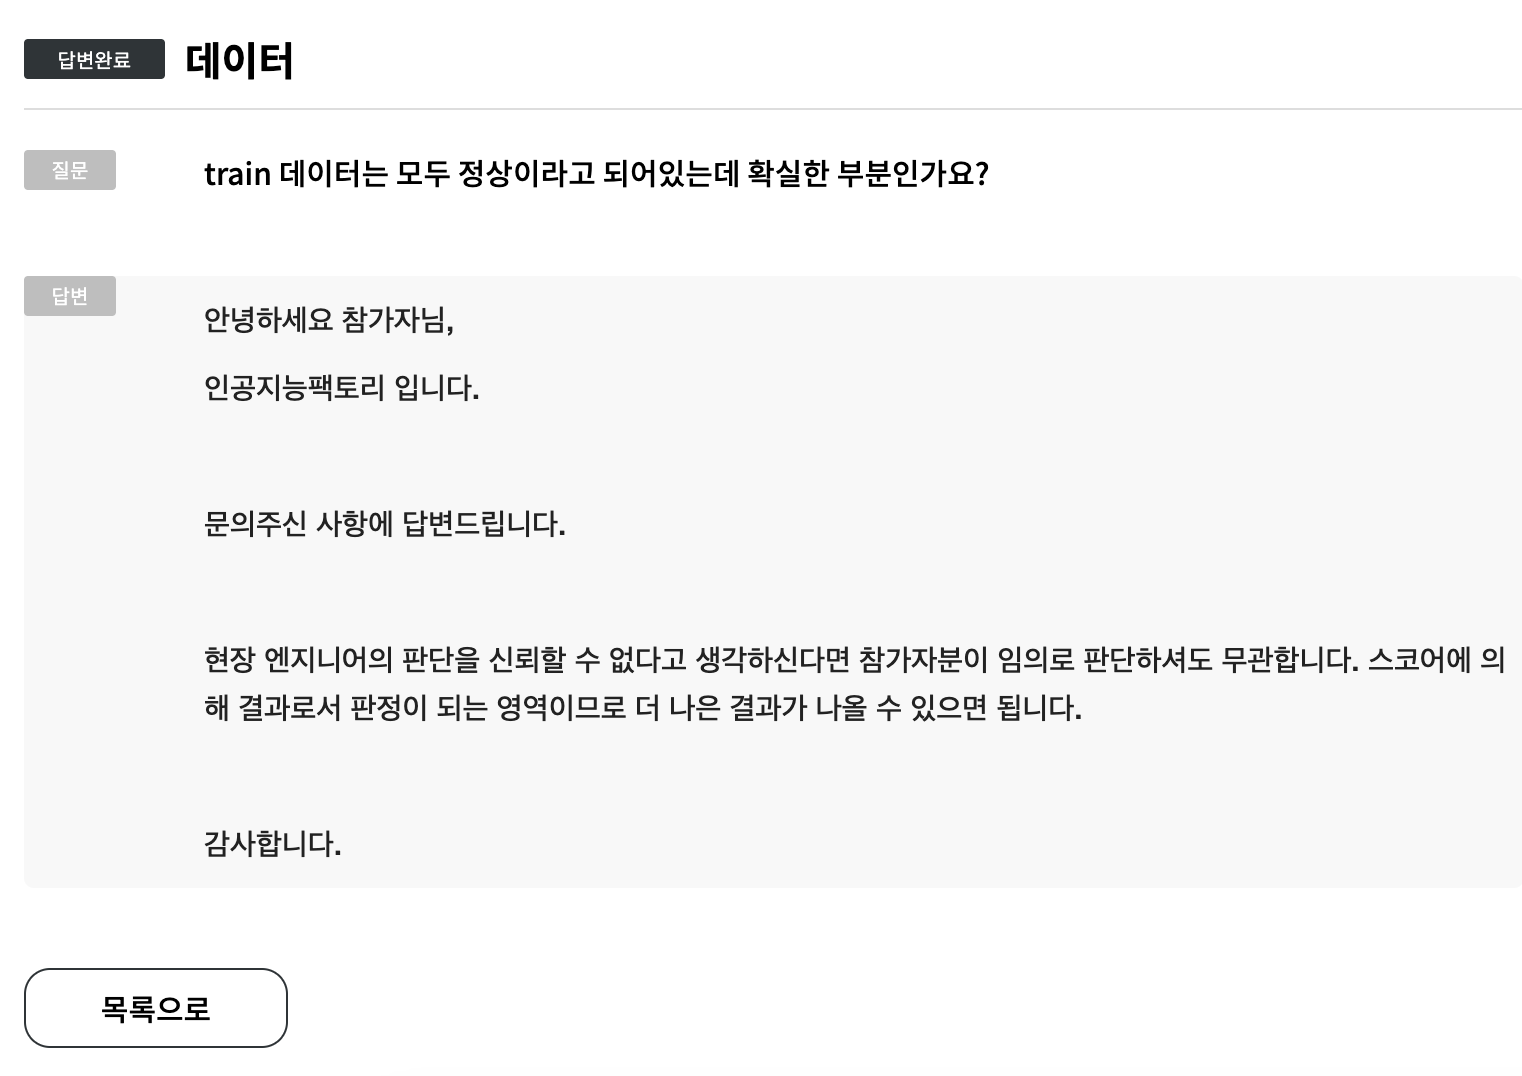

### type별 시각화
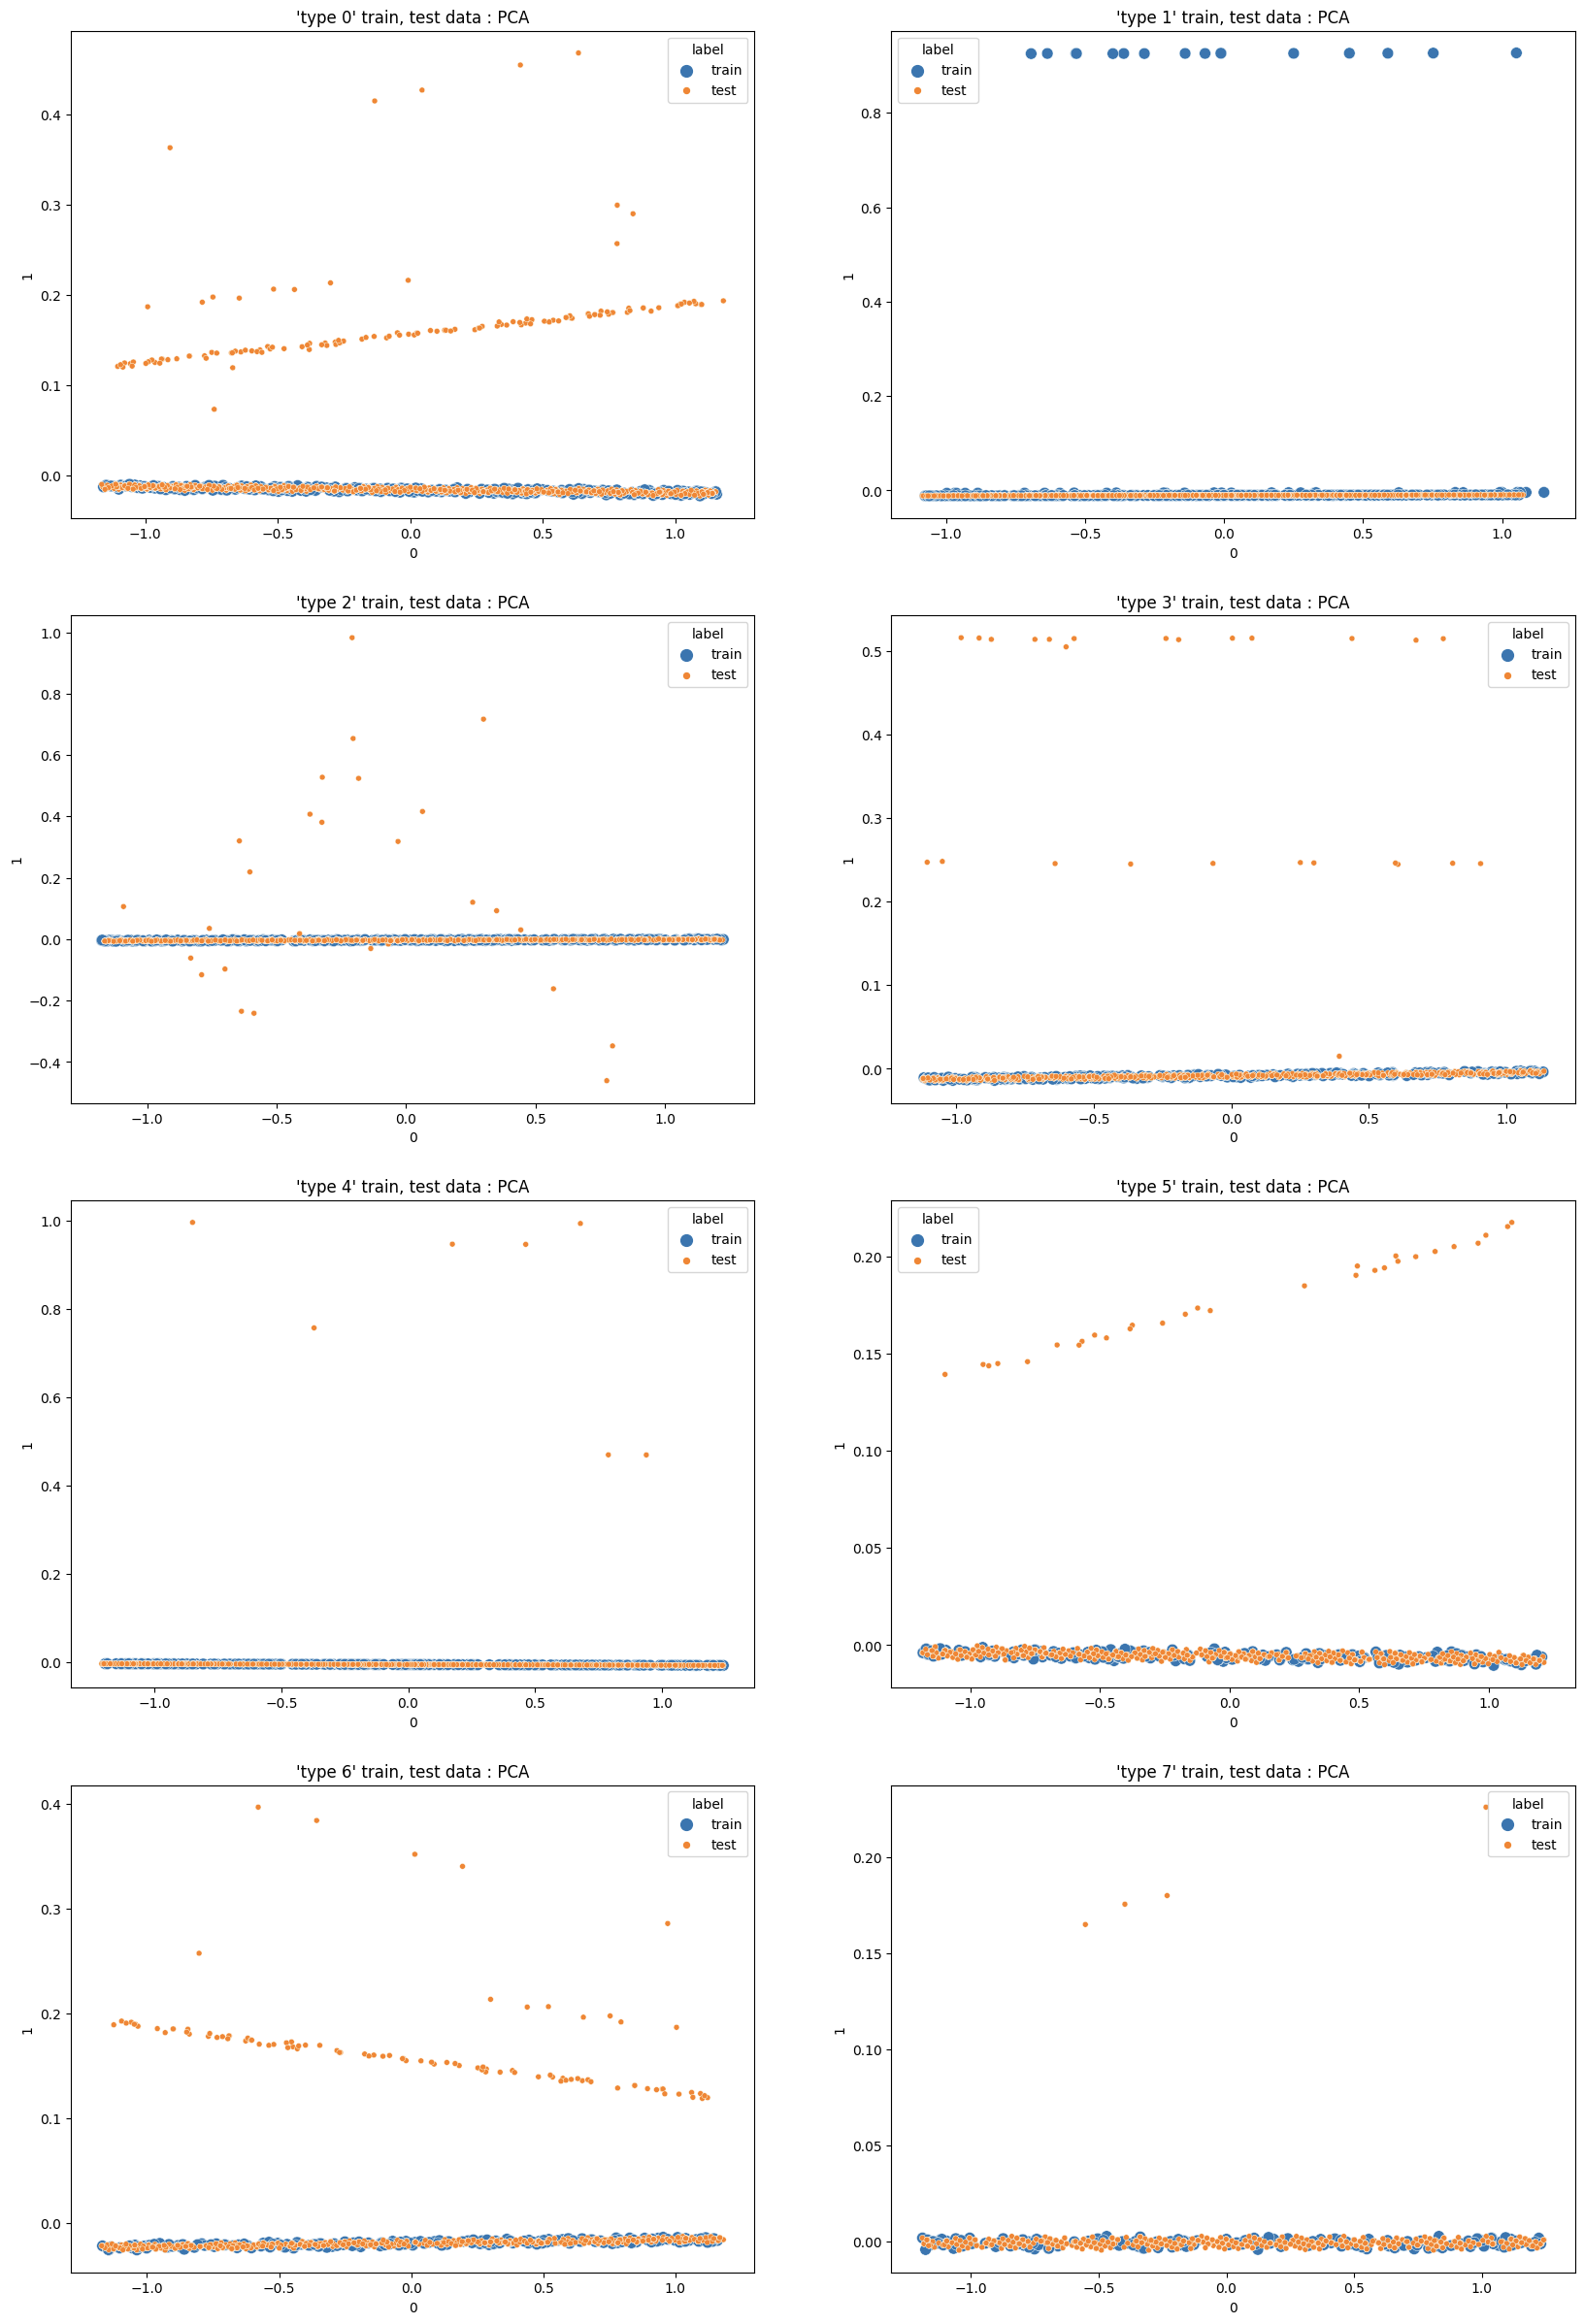

- 위와 같이 type별로 train, test 데이터에 대해 시각화를 진행해본 결과, type1에 해당하는 train 데이터에 비정상 데이터가 존재하는 것을 확인했다.
- Q&A에 답변해주신 것처럼 현장 엔지니어의 실수가 있을 수 있었다고 판단하여, train 데이터에도 이상치가 있다고 가정했다.
- train 데이터에서 발견된 이상 데이터는 총 48개 였으며, 해당 데이터가 test 데이터 내에 존재한다고 가정했다.
- 이에 test 데이터의 특정 위치에 비정상 데이터를 추가했다.

In [43]:
final.loc[1396:1443, 'label'] = 1

# 6. type 7에 대한 처리

- 공기압축기 데이터는 기계 작동 중에 모터 온도가 증가하고 진동이 증가하며 유량이 감소하는 이상 현상이 발생 시, 윤활유 공급 라인의 밸브를 off 상태에서 on 상태로 변경하여 정상화 시킨다.
- 이러한 과정에 대한 도메인 지식을 바탕으로 우리는 이상 데이터는 연속될 것이라고 판단했다. 
- 따라서 type7의 분산된 이상치는 연결되어야 한다고 판단하여, 분산된 이상치를 연결시켜주었다.

In [1]:
final.loc[7343:7349, 'label'] = 1

NameError: name 'final' is not defined

# 7. 최종 파일 저장

In [ ]:
# 최종 
final.to_csv('./answer_result.csv', index=False)